## Demo for power law fit/regresssion to MC errors as a function of number of samples   - Richard Sear 2018

Fits power law and estimate uncertainties in exponent using bootstrap error estimation method.

Specialised to case where data is on MC sampling errors, so we expect the errors to have CLT (Central Limit Theorem) of statistics form of sampling errr $\propto $ $N^{-1/2}$, for $N$ samples

Note that the maths behind estimating errors is pretty specialist and hairy stuff. This Jupyter Python notebook ignores this maths in favour of a being a cookbook with recipes for calculating estimates. Note that error ESTIMATES are just that, estimates, and so not guaranteed to be correct, in particular as the stats literature on these methods notes, all methods of obtaining error estimates make assumptions - if these assumptions are wrong so will be the error estimates. Notably the standard expressions given in stats textbooks (3 here) typically assume that the errors have a Gaussian distribution, which is often close to being true, but is not true in general.

The bootstrap method does not make this assumption, is a bit more flexible, and can be more accurate, than the jackknife method, and so is the one I would typically recommend. This [article](https://statistics.stanford.edu/sites/default/files/BIO%2083.pdf), although old, describes the idea of the bootstrap method very well, in a not-maths-heavy way. Note that the boostrap method can be used to give error estimates in anything where you are taking noisy data, and this article discusses the bootstrap method in estimating the error not in a fit but in estimating what they call the correlation coefficient.

Note that the bootstrap employs what is called resampling. Simply speaking the point of resampling is as follows. Ideally, we would like a huge number of data points, as then we could estimate the errors very accurately. More typically we only have a very limited number of points. We then use resampling that essentially recycles this small number of data points, by using them to approximately mimic the case where we had many more points.

Here data we are analysing is from Monte Carlo estimation of the value of $\pi$, see eg http://www.codeandfinance.com/estimating-pi-monte-carlo.html


In [12]:
# this makes the plots appear in this notebook
%matplotlib inline

######## We need to import modules into Python
# numpy is basic number crunching
import numpy as np
# need a generator for random integers
from random import randint,gauss,seed
# matplolib is plotting module
import matplotlib.pyplot as plt
###################

Normally you would read in data from a file - see commented out lines just below. But here, in order to make this IPython notebook self-contained, the data is built into the code as two arrays. The first array is N = the array of values of the number of samples used, and errors = the array of values of the errors. So first we generated $N=10$ points and obtained an estimate in error from the true value of $\pi$ by $4.584\times 10^{-1}$, then we generated another set of $N=22$ points and obtained an estimate for $\pi$ in error by $1.311\times 10^{-1}$, and so on. The errors are the absolute errors, ie the magnitude of the difference between the estimate and the true value.



In [13]:
# Normally read in data from a file, eg as in three lines immediately below, you can comment out and edit to do that 
#input_data=np.loadtxt("error_pi_vs_n.dat")
#N=input_data[:,0]
#errors=input_data[:,1]
#print(N)
##############
# data from estimation of pi via MC sampling of points inside a circle inside a square below
N=[1.0000000e+01, 2.2000000e+01, 4.6000000e+01, 1.0000000e+02, 2.1500000e+02, 
   4.6400000e+02, 1.0000000e+03, 2.1540000e+03, 4.6420000e+03, 1.0000000e+04,
   2.1544000e+04, 4.6416000e+04, 1.0000000e+05, 2.1544400e+05, 4.6415900e+05,
   1.0000000e+06, 2.1544360e+06, 4.6415870e+06, 1.0000000e+07, 2.1544354e+07]

errors=[4.58407164e-01, 1.31134510e-01, 2.49711514e-01, 6.15928173e-02,
        1.14221096e-01, 1.15730763e-01, 3.44073772e-02, 5.52418232e-02,
        1.39436722e-02, 1.07927322e-02, 2.56538400e-04, 1.55081749e-02,
        2.11262700e-03, 1.29365920e-03, 2.60567670e-03, 2.15530400e-03,
        8.91447100e-04, 1.83582300e-04, 5.25236100e-04, 2.66761780e-02]
#
n_pts=len(N)
print('data has ',n_pts,' points')


data has  20  points


power law fitst almost always best done by taking logs and fitting straight line, here for error $e$ a function of $N$ instead of fitting

$e=aN^b$        

with fit parameters $a$ and $b$

fit

$\ln e= \ln a + b \ln N = A + b\ln N$

with fit parameters $A$ and $b$

With this in mind we create arrays of logs of $N$ and of the absolute errors

In [14]:
lne=np.log(errors)
lnN=np.log(N)

Now define function to fit straight line $y = m*x + c$ to data - arrays $\ln N$ and $\ln e$

In [15]:
def linear_fit_calc(xf,yf):
    n_ptsf=len(xf)
# mean values
    mean_xf=np.average(xf)
    mean_yf=np.average(yf)
# first calculate arrays of x minus its mean value
    delta_xf=xf-mean_xf
    delta_yf=yf-mean_yf
# now for best-fit slope m
    m=np.sum(delta_xf*delta_yf)/np.sum(delta_xf**2)
# and best-fit intercept
    c=mean_yf-m*mean_xf
    return m,c

In [16]:
# a straight line of form y = intercept + slope*x is polynomial of order 1
# can change 1 to 2 to fit quadratic polynomial
#slope, intercept =np.polyfit(x,y,1)
#print(slope,intercept)
slope,intercept=linear_fit_calc(lnN,lne)
print('best fit value of intercept ','%6.3f'%(intercept),' from least squares fitting')
print('best fit value of slope = power law exponent ','%6.3f'%(slope))
bf_exponent=slope

best fit value of intercept  -0.467  from least squares fitting
best fit value of slope = power law exponent  -0.423


Now do boostrap error analysis, first define a function to do this. Wikipedia page for bootstrap is https://en.wikipedia.org/wiki/Bootstrapping_(statistics).

In [17]:
def bootstrap_calc(prob_conf_interval):
# here I have set the number of times the resampled to 1000, this kind of overkill - making it 100 does not change the
# error estimates much - but as the program runs so quickly it would not run noticeably faster if n_bootstrap
# is reduced so might as well make n_bootstrap large
    n_bootstrap=1000
    slope_boot=np.zeros(n_bootstrap)
    intercept_boot=np.zeros(n_bootstrap)
    for i in range(0,n_bootstrap):
        x_boot=np.zeros(n_pts)
        y_boot=np.zeros(n_pts)
        for j in range(0,n_pts):
            i_sample=randint(0,n_pts-1)
            x_boot[j]=lnN[i_sample]
            y_boot[j]=lne[i_sample]
        slope_boot[i],intercept_boot[i]=linear_fit_calc(x_boot,y_boot)#np.polyfit(x_boot,y_boot,1)
# sort so later we pick out values near bottom and top
    intercept_boot=np.sort(intercept_boot)
    slope_boot=np.sort(slope_boot)
# now n_bootstrap values are sorted from smallest to largest
    f_lower=(1.0-prob_conf_interval)/2.0
    f_upper=1.0-f_lower
    print('lower and upper limits to confidence interval ',format(f_lower,"4.2f"),'&',format(f_upper,"4.2f"))
# 95% level confidence - 95% is just a reasonable but basically arbitrary choice
    n_boot_lower_conf=int(float(n_bootstrap)*f_lower)
    n_boot_upper_conf=int(float(n_bootstrap)*f_upper)
    min_intercept_boot=intercept_boot[n_boot_lower_conf]
    max_intercept_boot=intercept_boot[n_boot_upper_conf]
    min_slope_boot=slope_boot[n_boot_lower_conf]
    max_slope_boot=slope_boot[n_boot_upper_conf]
    return min_intercept_boot,max_intercept_boot,min_slope_boot,max_slope_boot,intercept_boot,slope_boot
#########################

Now call this function to get the results, hopefully the confidence interval of the slope will include what we expect to be the true value $=-1/2$.

In [18]:
# Bootstrap estimates for statistical error bounds
# making this closer to 1 makes interval larger - more conservative error estimates
prob_conf_interval=0.95
print('estimate that',format(prob_conf_interval*100.0,"4.1f"),'% of the bootstrap sampled values fall with the confidence interval')
min_intercept_boot,max_intercept_boot,min_slope_boot,max_slope_boot,intercept_boot,slope_boot=bootstrap_calc(prob_conf_interval)
print('')
print('after boootstrap error analysis the data constrains the fit parameters to ranges:')
print('best fit value of intercept ',format(intercept,"5.2f"),format(prob_conf_interval*100.0,"5.1f"),
      '% conf. interval ',format(min_intercept_boot,"5.2f"),' to ',format(max_intercept_boot,"5.2f"))
print('best fit value of slope     ',format(slope,"5.2f"),format(prob_conf_interval*100.0,"5.1f"),
      '% conf. interval ','%5.2f'%(min_slope_boot),' to ','%5.2f'%(max_slope_boot))

estimate that 95.0 % of the bootstrap sampled values fall with the confidence interval
lower and upper limits to confidence interval  0.03 & 0.97

after boootstrap error analysis the data constrains the fit parameters to ranges:
best fit value of intercept  -0.47  95.0 % conf. interval  -1.91  to   0.62
best fit value of slope      -0.42  95.0 % conf. interval  -0.56  to  -0.26


Now plot data, best-fit, plus bootstrap error estimates to give rough idea of lowest reasonable line and highest reasonable line

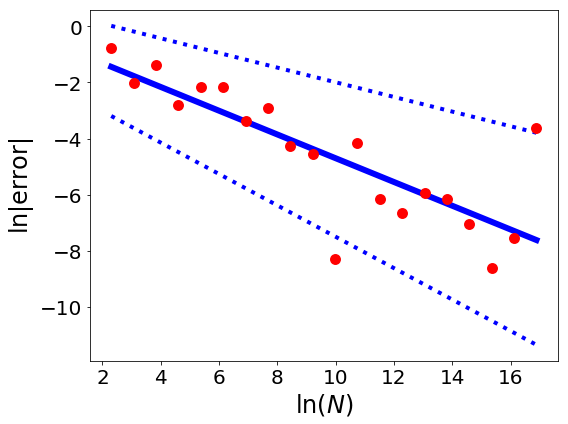

In [19]:
########### PLOT
# first generate points for fitted function
n_fitpts=10
x_fit=np.linspace(np.min(lnN),np.max(lnN),n_fitpts)
# this is the best fit
y_fit=intercept+slope*x_fit
# now for fit 5/100 lowest intercept & slope
y_fit_lower_conf=min_intercept_boot+min_slope_boot*x_fit
# now for fit 95/100 intercept & slope
y_fit_upper_conf=max_intercept_boot+max_slope_boot*x_fit
######### Now generate plot
plt.figure(figsize = (8,6) )
# plot data as scatter plot,
plt.scatter(lnN,lne,s=120,color='red',linewidth=0,label='data',zorder=2)
# plot fitted function, zorder = 1 < 2 so line underneath points
plt.plot(x_fit,y_fit,linewidth=6,color='blue', label='fit',zorder=1)
# plot estimates of lower and upper 
plt.plot(x_fit,y_fit_lower_conf,linewidth=4,c='blue',linestyle=':',zorder=1,label='error est.')
plt.plot(x_fit,y_fit_upper_conf,linewidth=4,c='blue',linestyle=':',zorder=1)
plt.xlabel('$\ln (N)$',fontsize=24)
plt.ylabel('$\ln |$error$|$',fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.legend(loc='upper left',fontsize=24)
plt.tight_layout()
#	plt.legend(loc='upper right')
#	plt.axhline(color = 'gray', zorder=-1)
# save plot to file
#plt.savefig('tmp.pdf')
# display plot on screen
plt.show()

and replot not $\ln N$ and $\ln |$error$|$ but $N$ and the error, but on a log-log scale

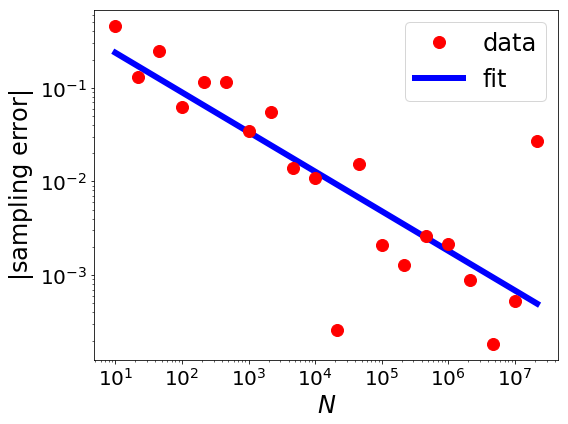

In [20]:
########### PLOT on log log scale

# first generate points for fitted function
n_fitpts=10
x_fit=np.linspace(np.min(lnN),np.max(lnN),n_fitpts)
# this is the best fit
y_fit=intercept+slope*x_fit
# now for fit 5/100 lowest intercept & slope
y_fit_lower_conf=min_intercept_boot+min_slope_boot*x_fit
# now for fit 95/100 intercept & slope
y_fit_upper_conf=max_intercept_boot+max_slope_boot*x_fit
######### Now generate plot
plt.figure(figsize = (8,6) )

# plot data as scatter plot,
plt.loglog(N,errors,marker='o',markersize=12,color='red',linewidth=0,label='data',zorder=2)
# plot fitted function, zorder = 1 < 2 so line underneath points
plt.loglog(np.exp(x_fit),np.exp(y_fit),linewidth=6,color='blue', label='fit',zorder=1)
# plot estimates of lower and upper 
#plt.plot(x_fit,y_fit_lower_conf,linewidth=4,c='blue',linestyle=':',zorder=1,label='error est.')
#plt.plot(x_fit,y_fit_upper_conf,linewidth=4,c='blue',linestyle=':',zorder=1)
plt.xlabel('$N$',fontsize=24)
plt.ylabel('$|$sampling error$|$',fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='upper right',fontsize=24)
plt.tight_layout()
#	plt.axhline(color = 'gray', zorder=-1)
# save plot to file
#plt.savefig('tmp.pdf')
# display plot on screen
plt.show()

# Brief digression on checking if chosen fitting function (here straight line) is a reasonable choice

So far we have looked at the problem:if we ASSUME that the data is a straight line plus noise, what are our estimates for the values of the two parameters, intercept and slope, that define a straight line. This error analysis says essentially NOTHING about whether this assumption that the data really is a straight line, is true or false.

Perhaps the best simple check on the assumption for the functional form we chose for fitting, here a straight line, is to plot the residuals, ie the y values of the data minus the y values from the fit, as a function of x. IF the data really are a straight line plus noise, these residuals should just be random noise, ie no trend to increase or decreases with x. However, if the straight line is not the correct functional form, they a pattern in the residuals may be apparent.

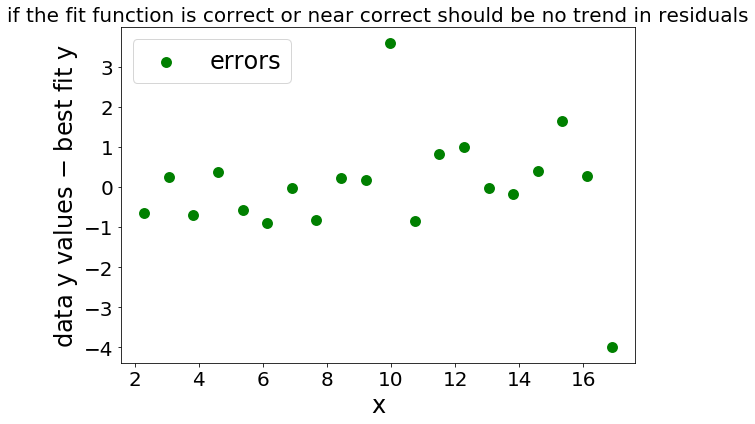

In [21]:
## plot errors to look for trend
######### Now generate plot
plt.figure(figsize = (10,6) )
# plot data as scatter plot,
plt.title('if the fit function is correct or near correct should be no trend in residuals',fontsize=20)
# these are the error or residuals in y values
y_error=intercept+slope*lnN - lne
plt.scatter(lnN,y_error,s=120,c='green',linewidth=0,label='errors',zorder=2)
plt.xlabel('x',fontsize=24)
plt.ylabel('data y values $-$ best fit y',fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='upper left',fontsize=24)
plt.tight_layout()
plt.show()

Note that these residuals just look like noise, ie no trend - as they should, we know that the data should be a straight line plus noise.

# Brief digression on distribution of best-fit estimates, from bootstrap

This is usually overkill for analysing a fit to data, but it might help you appreciate that the predicted intercept and slope are best guesses, if we plot the histograms of the values for the intercept and slope, obtained by bootstrapping. So we now do this.

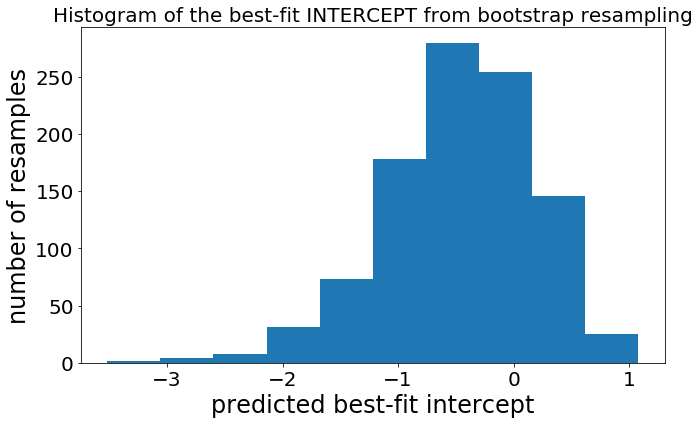

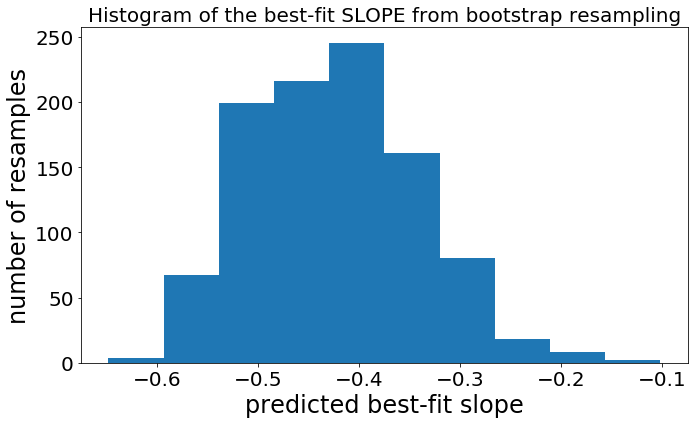

In [22]:
plt.figure(figsize = (10,6) )
# plot data as scatter plot,
plt.title('Histogram of the best-fit INTERCEPT from bootstrap resampling',fontsize=20)
plt.hist(intercept_boot)
plt.xlabel('predicted best-fit intercept',fontsize=24)
plt.ylabel('number of resamples',fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.show()
plt.figure(figsize = (10,6) )
# plot data as scatter plot,
plt.title('Histogram of the best-fit SLOPE from bootstrap resampling',fontsize=20)
plt.hist(slope_boot)
plt.xlabel('predicted best-fit slope',fontsize=24)
plt.ylabel('number of resamples',fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.savefig('slope.png')
plt.show()